In [2]:
try:
  import qiskit
  import qiskit_aer
  import qiskit_nature
  import qiskit_ibm_runtime
  import pyscf
  import pylatexenc
except:
  !pip install qiskit qiskit-aer qiskit-ibm-runtime qiskit_nature pyscf pylatexenc

# General imports
import numpy as np

# Qiskit Runtime
from qiskit.primitives import Estimator

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper, InterleavedQubitMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeKolkata



from datetime import datetime


In [4]:
dist = 1.0

In [5]:
# IMPORTANT
def draw_orbitals(problem):
    # Draw orbitals (method provided by Max)
    print(f'Number of particles : {problem.num_particles}')
    print(f'Number of spatial orbitals : {problem.num_spatial_orbitals}')
    print(f'Orbital energies : {problem.orbital_energies}')

    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    for i in range(problem.num_spatial_orbitals):
        if problem.orbital_occupations[i] == 1:
            co = 'tab:blue'
        else:
            co = 'tab:green'

        ax.scatter(i,np.log10(np.abs(problem.orbital_energies[i])), s=15, c=co, marker='o')

    ax.set_xlabel('Orbital', fontsize=15)
    ax.set_ylabel(r'$\log\left(|E|\right)$', fontsize=15)

    ax.scatter(-2,2,s=15, c='tab:blue', marker='o', label='Occupied orbitals')
    ax.scatter(-2,2,s=15, c='tab:green', marker='o', label='Empty orbitals')
    ax.set_xlim(-0.2,problem.num_spatial_orbitals+0.2)
    ax.set_ylim(np.amin(np.log10(np.abs(problem.orbital_energies)))-0.2,
                np.amax(np.log10(np.abs(problem.orbital_energies)))+0.2)
    ax.legend(loc='best', fontsize=15)

def get_freezed_problem(properties, indexes = None):
    # Shortcut for the problem definition
    return FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=indexes
    ).transform(properties)



## other funcs copied

In [6]:
def exact_solver(qubit_op, problem):
  sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
  result = problem.interpret(sol)
  return result

## func for convenient experimental loop

In [7]:
def Experiment(
  molecule,
  orbitals_to_fix,
  optimizer=COBYLA(maxiter=15, tol=0.0001),
  output_info=True,
  if_draw_orbitals=False,
):
  '''
  returns pair of (exact energy, vqe energy)
  '''
  print(f'= = = = = = = = = = = = = = = = = = = = = = = =\nExperiment started: {(datetime.now().time()).strftime("%H:%M:%S")}')  

  molecule = "".join(molecule)[:-1]
  driver = PySCFDriver(
      atom=molecule,
      unit=DistanceUnit.ANGSTROM,
      basis='sto3g',
      spin=0
  )
  properties_molecule = driver.run()
    
  problem = get_freezed_problem(properties_molecule, orbitals_to_fix)

  if (if_draw_orbitals):
    draw_orbitals(problem)
  if (output_info):
    print('. . . . . . . . . . . . . . . . . . .\n')
  
  # exact solver
  device = FakeKolkata()
  coupling_map = device.configuration().coupling_map
  noise_model = NoiseModel.from_backend(device)
  estimator = Estimator(
        backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
    )
  num_particles = problem.num_particles
  num_spatial_orbitals = problem.num_spatial_orbitals
  mapper = ParityMapper(num_particles=num_particles)
  # mapper = JordanWignerMapper()
  qubit_op = mapper.map(problem.second_q_ops()[0])
  
  exact_result = exact_solver(qubit_op, problem)
  if (output_info):
    print(exact_result)
    print(f'Exact solver done: {(datetime.now().time()).strftime("%H:%M:%S")}')
  
  
  # VQE
  init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
  # TODO: maybe try EfficientSU2 instead of UCCSD
  ansatz = UCCSD(
      num_spatial_orbitals, num_particles, mapper, initial_state=init_state
  )
  if (output_info):
    current_time = datetime.now().time()
    print(f'ansatz initialized, {current_time.strftime("%H:%M:%S")}')
    print(f'ansatz.depth = {ansatz.depth()}')
    print(f'num of qubits = {ansatz.num_qubits}')
  
  vqe = VQE(
        estimator,
        ansatz,
        optimizer,
        initial_point=[0] * ansatz.num_parameters,
    )
  vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
  if (output_info):
    current_time = datetime.now().time()
    print(f'VQE compute_minimum_eigenvalue done, {current_time.strftime("%H:%M:%S")}')

  vqe_result = problem.interpret(vqe_calc)
  if (output_info):
    print(
      f"VQE Result: {vqe_result}\n",
      f"Exact Energy: {exact_result}\n"
    )
  return (exact_result, vqe_result)

In [16]:
lioh_dist_domain = np.linspace(0.1, 2, 10)

exact_energies = []
vqe_energies = []
angle = 104

for dist in lioh_dist_domain:
  molecule = [
    'H -'+str(dist)+' .0 .0;',
    'O .0 .0 .0;',
    'H '+str(dist * np.cos(np.deg2rad(180 - angle)))+' '+str(dist * np.sin(np.deg2rad(180 - angle)))+' .0;',
    ]
  print(f"{dist = }")
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)
  exact_energies.append(exact_val)
  vqe_energies.append(vqe_val)
  
  

dist = 0.1
= = = = = = = = = = = = = = = = = = = = = = = =
Experiment started: 14:01:21
. . . . . . . . . . . . . . . . . . .



/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -108.500230996718
  - computed part:      -18.615495464953
  - FreezeCoreTransformer extracted energy part: -89.884735531765
~ Nuclear repulsion energy (Hartree): 88.026031345494
> Total ground state energy (Hartree): -20.474199651224
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.143256  0.18335932  0.0]
 
Exact solver done: 14:01:22
ansatz initialized, 14:01:22
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:01:46
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -102.735138935102
  - computed part:      -12.850403403337
  - FreezeCoreTransformer extracted energy part: -89.884735531765
~ Nuclear repulsion energy (Hartree): 88.026031345494
> Total ground state energy (Hartree): -14.709107589608
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.143256  0.183

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -95.609952248276
  - computed part:      -17.029236404007
  - FreezeCoreTransformer extracted energy part: -78.580715844269
~ Nuclear repulsion energy (Hartree): 28.294081503909
> Total ground state energy (Hartree): -67.315870744367
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.44568533  0.57045121  0.0]
 
Exact solver done: 14:01:46
ansatz initialized, 14:01:46
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:02:10
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -91.88612007293
  - computed part:      -13.305404228662
  - FreezeCoreTransformer extracted energy part: -78.580715844269
~ Nuclear repulsion energy (Hartree): 28.294081503909
> Total ground state energy (Hartree): -63.592038569022
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.44568533  0.57

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -90.269195543704
  - computed part:      -15.303863890742
  - FreezeCoreTransformer extracted energy part: -74.965331652962
~ Nuclear repulsion energy (Hartree): 16.85604855552
> Total ground state energy (Hartree): -73.413146988183
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.74811467  0.95754311  0.0]
 
Exact solver done: 14:02:11
ansatz initialized, 14:02:11
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:02:35
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -87.211016392473
  - computed part:      -12.245684739511
  - FreezeCoreTransformer extracted energy part: -74.965331652962
~ Nuclear repulsion energy (Hartree): 16.85604855552
> Total ground state energy (Hartree): -70.354967836953
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.74811467  0.957

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -86.723332055327
  - computed part:      -13.972308421964
  - FreezeCoreTransformer extracted energy part: -72.751023633363
~ Nuclear repulsion energy (Hartree): 12.003549728931
> Total ground state energy (Hartree): -74.719782326396
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.050544  1.344635  0.0]
 
Exact solver done: 14:02:35
ansatz initialized, 14:02:35
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:02:59
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.120494091907
  - computed part:      -11.369470458543
  - FreezeCoreTransformer extracted energy part: -72.751023633363
~ Nuclear repulsion energy (Hartree): 12.003549728931
> Total ground state energy (Hartree): -72.116944362976
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.050544  1.344635 

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.288147520905
  - computed part:      -12.853067900322
  - FreezeCoreTransformer extracted energy part: -71.435079620584
~ Nuclear repulsion energy (Hartree): 9.320403318935
> Total ground state energy (Hartree): -74.96774420197
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.35297333  1.73172689  0.0]
 
Exact solver done: 14:03:00
ansatz initialized, 14:03:00
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:03:23
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.1557339226
  - computed part:      -10.720654302016
  - FreezeCoreTransformer extracted energy part: -71.435079620584
~ Nuclear repulsion energy (Hartree): 9.320403318935
> Total ground state energy (Hartree): -72.835330603665
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.35297333  1.731726

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.552153048853
  - computed part:      -11.896142550158
  - FreezeCoreTransformer extracted energy part: -70.656010498695
~ Nuclear repulsion energy (Hartree): 7.617637327975
> Total ground state energy (Hartree): -74.934515720878
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.65540266  2.11881879  0.0]
 
Exact solver done: 14:03:24
ansatz initialized, 14:03:24
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:03:48
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -80.841397797145
  - computed part:      -10.18538729845
  - FreezeCoreTransformer extracted energy part: -70.656010498695
~ Nuclear repulsion energy (Hartree): 7.617637327975
> Total ground state energy (Hartree): -73.223760469169
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.65540266  2.1188

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -81.267419882102
  - computed part:      -11.10774114591
  - FreezeCoreTransformer extracted energy part: -70.159678736192
~ Nuclear repulsion energy (Hartree): 6.440929122841
> Total ground state energy (Hartree): -74.826490759261
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.957832  2.50591068  0.0]
 
Exact solver done: 14:03:49
ansatz initialized, 14:03:49
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:04:12
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -79.696878226723
  - computed part:      -9.537199490531
  - FreezeCoreTransformer extracted energy part: -70.159678736192
~ Nuclear repulsion energy (Hartree): 6.440929122841
> Total ground state energy (Hartree): -73.255949103882
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.957832  2.50591068 

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -80.288226323989
  - computed part:      -10.48350643703
  - FreezeCoreTransformer extracted energy part: -69.804719886959
~ Nuclear repulsion energy (Hartree): 5.579114662743
> Total ground state energy (Hartree): -74.709111661246
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.26026133  2.89300258  0.0]
 
Exact solver done: 14:04:13
ansatz initialized, 14:04:13
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:04:40
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -78.819431811172
  - computed part:      -9.014711924213
  - FreezeCoreTransformer extracted energy part: -69.804719886959
~ Nuclear repulsion energy (Hartree): 5.579114662743
> Total ground state energy (Hartree): -73.24031714843
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.26026133  2.893002

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -79.524415511655
  - computed part:      -9.9956395563
  - FreezeCoreTransformer extracted energy part: -69.528775955355
~ Nuclear repulsion energy (Hartree): 4.920709826767
> Total ground state energy (Hartree): -74.603705684889
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.56269066  3.28009447  0.0]
 
Exact solver done: 14:04:41
ansatz initialized, 14:04:41
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:05:08
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -78.218461976215
  - computed part:      -8.68968602086
  - FreezeCoreTransformer extracted energy part: -69.528775955355
~ Nuclear repulsion energy (Hartree): 4.920709826767
> Total ground state energy (Hartree): -73.297752149449
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.56269066  3.28009447

/tmp/ipykernel_61173/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_61173/1832985086.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -78.916549037307
  - computed part:      -9.612561998282
  - FreezeCoreTransformer extracted energy part: -69.303987039025
~ Nuclear repulsion energy (Hartree): 4.401301567275
> Total ground state energy (Hartree): -74.515247470033
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.86512  3.66718636  0.0]
 
Exact solver done: 14:05:09
ansatz initialized, 14:05:09
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 14:05:33
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -77.596279695347
  - computed part:      -8.292292656322
  - FreezeCoreTransformer extracted energy part: -69.303987039025
~ Nuclear repulsion energy (Hartree): 4.401301567275
> Total ground state energy (Hartree): -73.194978128072
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.86512  3.66718636  0

In [20]:
exact_energies_fixed = []
vqe_energies_fixed = []
for el, vl in zip(exact_energies,vqe_energies):
  exact_energies_fixed.append(el.electronic_energies[0] + el.nuclear_repulsion_energy)
  vqe_energies_fixed.append(vl.electronic_energies[0] + vl.nuclear_repulsion_energy)
  

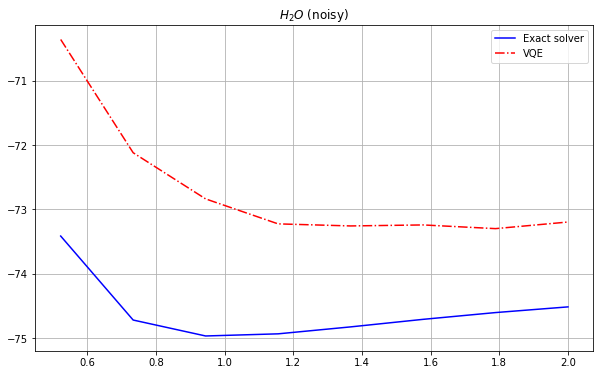

In [21]:
import matplotlib.pyplot as plt

index = 2

plt.figure(figsize=(10, 6))
plt.plot(lioh_dist_domain[index:], exact_energies_fixed[index:], label='Exact solver', linestyle='-', color='b')
plt.plot(lioh_dist_domain[index:], vqe_energies_fixed[index:], label='VQE', linestyle='dashdot', color='r')
plt.title('$H_2O$ (noisy)')
plt.grid()
plt.legend(loc='best')
plt.show()

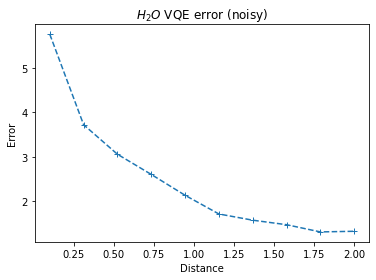

In [22]:
# The error commited at every step remain small

fig, ax = plt.subplots()
# ax.plot(lioh_dist_domain,np.log10(np.abs([vqe_energies[i] - exact_energies_fixed[i] for i in range(len(lioh_dist_domain))])),'+--')
ax.plot(lioh_dist_domain,(np.abs([vqe_energies[i].electronic_energies[0] - exact_energies[i].electronic_energies[0] for i in range(len(lioh_dist_domain))])),'+--')

ax.set_xlabel("Distance")
ax.set_ylabel("Error")
plt.title('$H_2O$ VQE error (noisy)')

plt.draw()

In [ ]:
np.min(exact_energies_fixed)  # H2

np.float64(-1.1373057587800393)